In [2]:
!pip install networkx==2.5
!pip install pgmpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.1 MB/s eta 0:00:00


In [3]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
import pandas as pd


# Dataset

In [4]:
!rm -r pgm
!git clone https://github.com/cbelloda/pgm.git

rm: cannot remove 'pgm': No such file or directory
Cloning into 'pgm'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (6/6), 174.06 KiB | 2.90 MiB/s, done.


In [5]:
df = pd.read_csv('pgm/f_2023_11_17.csv',delimiter=';')

df.head()

,libroreclamaciones_id,codigo_reclamo,fecha_registro,store,LOCALES,TIPO DE PEDIDO,DIAS FESTIVOS,Mal Servicio,Mal Producto,Error de Cobro,...,padremadre_cliente,tiposervicio,descripcion_tiposervicio,tipo_reclamo,ID_DESC_RECLAMO,descripcion_reclamo,acciones_proveedor,distrito_cliente,monto_tiposervicio,pedido_reclamo
0,3,FRID-001-0003,30/10/2021 01:12,Fridays Salaverry,NaN,LOCAL,1,1,0,1,...,NaN,servicio,El día 22 de octubre nos reunimos en la barra ...,queja,1,Se nos cobro 2 veces por un servicio fue efect...,NaN,Lima,126.0,126.0
1,5,FRID-001-0005,19/11/2021 18:58,Fridays Larcomar,NaN,LOCAL,0,0,1,0,...,NaN,producto,Pedí pasta y me vino un pedazo de bolsa en la ...,reclamo,2,Pedí pasta y me vino un pedazo de bolsa en la ...,NaN,Lima,32.0,32.0
2,7,FRID-001-0007,21/11/2021 23:38,Fridays Jockey Plaza,NaN,DELIVERY,0,1,0,0,...,NaN,servicio,NaN,reclamo,3,El día de hoy fui atendido por la mesera 20005...,NaN,Lima,0.0,0.0
3,10,FRID-001-0010,26/11/2021 03:27,Fridays Jockey Plaza,NaN,LOCAL,0,0,0,0,...,NaN,servicio,"Demora para servir un triple chiken sample, ot...",reclamo,4,"Demora para servir un triple chiken sample, ot...",NaN,Lima,108.0,108.0
4,14,FRID-001-0014,6/12/2021 17:16,"Fridays La Rambla, San Borja",NaN,LOCAL,0,1,0,1,...,NaN,servicio,COBRO DOBLE,reclamo,5,"El día sábado consumí en Rambla de San Borja, ...",NaN,Lima,163.0,163.0


In [6]:
### obtenemos las variables de interés

df_select = df[['TIPO DE PEDIDO','DIAS FESTIVOS','Mal Servicio','Mal Producto','Demora','MAL AMBIENTE','SEXO','REGION','CALLCENTER']]


df_select.insert(loc=len(df_select.columns), column='Presenta reclamo', value='Sí')

variables_model = {
  'TYPESERVICE':{'abbreviation':'TA','name':'Tipo de Atención','values':['Local','Delivery']},
  'SUNDHOLI' :{'abbreviation':'DF','name':'Es domingo o feriado','values':['No','Sí']},
  'SERVICE' : {'abbreviation':'S','name':'Servicio','values':['Bueno','Malo']},
  'PRODUCT' : {'abbreviation':'P','name':'Producto','values':['Bueno','Malo']},
  'DELAY' : {'abbreviation':'D','name':'Demora','values':['Sí','No']},
  'ATMOSPHERE': {'abbreviation':'A','name':'Ambiente','values':['Agradable','Desagradable']},
  'GENRE': {'abbreviation':'G','name':'Género','values':['Masculino','Femenino']},
  'REGION': {'abbreviation':'RG','name':'Región','values':['Norte','Sur']},
  'CALLCENTER' : {'abbreviation':'C','name':'Callcenter','values':['No llamó','Llamó']},
  'CLAIM': {'abbreviation':'R','name':'Presenta reclamo','values':['Sí','No'] }
}



df_select = df_select.rename(columns={'TIPO DE PEDIDO':variables_model['TYPESERVICE']['name'],'DIAS FESTIVOS':variables_model['SUNDHOLI']['name'],'Mal Servicio':variables_model['SERVICE']['name'],'Mal Producto':variables_model['PRODUCT']['name'],'Demora':variables_model['DELAY']['name'],'MAL AMBIENTE':variables_model['ATMOSPHERE']['name'],'SEXO':variables_model['GENRE']['name'],'REGION':variables_model['REGION']['name'],'CALLCENTER':variables_model['CALLCENTER']['name']})

variables_model['TYPESERVICE']['values'][0]

df_select[variables_model['TYPESERVICE']['name']] = df_select[variables_model['TYPESERVICE']['name']].replace({'LOCAL': variables_model['TYPESERVICE']['values'][0], 'DELIVERY': variables_model['TYPESERVICE']['values'][1]})
df_select[variables_model['SUNDHOLI']['name']] = df_select[variables_model['SUNDHOLI']['name']].replace({0: variables_model['SUNDHOLI']['values'][0], 1: variables_model['SUNDHOLI']['values'][1]})
df_select[variables_model['SERVICE']['name']] = df_select[variables_model['SERVICE']['name']].replace({0: variables_model['SERVICE']['values'][0], 1: variables_model['SERVICE']['values'][1]})
df_select[variables_model['PRODUCT']['name']] = df_select[variables_model['PRODUCT']['name']].replace({0: variables_model['PRODUCT']['values'][0], 1: variables_model['PRODUCT']['values'][1]})
df_select[variables_model['DELAY']['name']] = df_select[variables_model['DELAY']['name']].replace({0: variables_model['DELAY']['values'][0], 1: variables_model['DELAY']['values'][1]})
df_select[variables_model['ATMOSPHERE']['name']] = df_select[variables_model['ATMOSPHERE']['name']].replace({0: variables_model['ATMOSPHERE']['values'][0], 1: variables_model['ATMOSPHERE']['values'][1]})
df_select[variables_model['GENRE']['name']] = df_select[variables_model['GENRE']['name']].replace({0: variables_model['GENRE']['values'][0], 1: variables_model['GENRE']['values'][1]})
df_select[variables_model['REGION']['name']] = df_select[variables_model['REGION']['name']].replace({0: variables_model['REGION']['values'][0], 1: variables_model['REGION']['values'][1]})
df_select[variables_model['CALLCENTER']['name']] = df_select[variables_model['CALLCENTER']['name']].replace({0: variables_model['CALLCENTER']['values'][0], 1: variables_model['CALLCENTER']['values'][1]})
df_select[variables_model['CLAIM']['name']] = df_select[variables_model['CLAIM']['name']].replace({0: variables_model['CLAIM']['values'][0], 1: variables_model['CLAIM']['values'][1]})


df_select.head()

,Tipo de Atención,Es domingo o feriado,Servicio,Producto,Demora,Ambiente,Género,Región,Callcenter,Presenta reclamo
0,Local,Sí,Malo,Bueno,Sí,Agradable,Femenino,Norte,No llamó,Sí
1,Local,No,Bueno,Malo,Sí,Desagradable,Femenino,Norte,No llamó,Sí
2,Delivery,No,Malo,Bueno,Sí,Agradable,Masculino,Sur,No llamó,Sí
3,Local,No,Bueno,Bueno,No,Agradable,Femenino,Sur,No llamó,Sí
4,Local,No,Malo,Bueno,Sí,Agradable,Femenino,Sur,No llamó,Sí


# Model

In [7]:
state_names = {v['name']: v['values']  for k, v in variables_model.items()}


print(state_names)


model = BayesianNetwork([(variables_model['SUNDHOLI']['name'],variables_model['DELAY']['name']),
(variables_model['REGION']['name'],variables_model['ATMOSPHERE']['name']),
(variables_model['REGION']['name'],variables_model['TYPESERVICE']['name']),
(variables_model['TYPESERVICE']['name'],variables_model['PRODUCT']['name']),
(variables_model['TYPESERVICE']['name'],variables_model['SERVICE']['name']),
(variables_model['CALLCENTER']['name'],variables_model['CLAIM']['name']),
(variables_model['PRODUCT']['name'],variables_model['CLAIM']['name']),
(variables_model['SERVICE']['name'],variables_model['CLAIM']['name']),
(variables_model['ATMOSPHERE']['name'],variables_model['CLAIM']['name']),
(variables_model['DELAY']['name'],variables_model['CLAIM']['name']),
(variables_model['GENRE']['name'],variables_model['CLAIM']['name'])
])








{'Tipo de Atención': ['Local', 'Delivery'], 'Es domingo o feriado': ['No', 'Sí'], 'Servicio': ['Bueno', 'Malo'], 'Producto': ['Bueno', 'Malo'], 'Demora': ['Sí', 'No'], 'Ambiente': ['Agradable', 'Desagradable'], 'Género': ['Masculino', 'Femenino'], 'Región': ['Norte', 'Sur'], 'Callcenter': ['No llamó', 'Llamó'], 'Presenta reclamo': ['Sí', 'No']}


In [8]:
from pgmpy.estimators import ParameterEstimator

pe = ParameterEstimator(model, df_select)
pe.state_counts(variables_model['CLAIM']['name']).head()


Ambiente         Agradable                                                     \
Callcenter           Llamó                                                      
Demora                  No                                                 Sí   
Género            Femenino                 Masculino                 Femenino   
Producto             Bueno       Malo          Bueno       Malo         Bueno   
Servicio             Bueno Malo Bueno Malo     Bueno Malo Bueno Malo    Bueno   
Presenta reclamo                                                                
Sí                       2    1   0.0    2       0.0    2   0.0  0.0      0.0   

Ambiente               ... Desagradable                                \
Callcenter             ...     No llamó                                 
Demora                 ...           No            Sí                   
Género                 ...    Masculino      Femenino                   
Producto               ...         Malo         Bueno       Malo        
Servicio         Malo  ...        Bueno Malo    Bueno Malo Bueno Malo   
Presenta reclamo       ...                                              
Sí                  4  ...            1    4        9   20    24    6   

Ambiente                                    
Callcenter                                  
Demora                                      
Género           Masculino                  
Producto             Bueno       Malo       
Servicio             Bueno Malo Bueno Malo  
Presenta reclamo                            
Sí                      10   19    12    7  

[1 rows x 64 columns]

## Estimación de CPDs con MaximumLikelihood

In [9]:
# Estimación de CPD utilizando MaximumLikelihoodEstimator con state_names
estimator = MaximumLikelihoodEstimator(model, df_select, state_names=state_names)


for node in model.nodes():
  cpd = estimator.estimate_cpd(node)
  print("CPD del nodo ====>  ",node)
  print(cpd)
  print("=====================================")


#model.fit(data=df_select, estimator=MaximumLikelihoodEstimator,state_names=state_names)



CPD del nodo ====>   Es domingo o feriado
+--------------------------+----------+
| Es domingo o feriado(No) | 0.790221 |
+--------------------------+----------+
| Es domingo o feriado(Sí) | 0.209779 |
+--------------------------+----------+
CPD del nodo ====>   Demora
+----------------------+--------------------------+--------------------------+
| Es domingo o feriado | Es domingo o feriado(No) | Es domingo o feriado(Sí) |
+----------------------+--------------------------+--------------------------+
| Demora(Sí)           | 0.7045908183632734       | 0.8045112781954887       |
+----------------------+--------------------------+--------------------------+
| Demora(No)           | 0.2954091816367265       | 0.19548872180451127      |
+----------------------+--------------------------+--------------------------+
CPD del nodo ====>   Región
+---------------+----------+
| Región(Norte) | 0.586751 |
+---------------+----------+
| Región(Sur)   | 0.413249 |
+---------------+----------+
CPD 

 deberíamos agregar otro tipo de estimación CPDBayesina estimator

In [10]:
best = BayesianEstimator(model=model, data=df_select, state_names=state_names)
cpds=[]
for node in model.nodes():
  print("CPD del nodo ====>  ",node)
  print(best.estimate_cpd(node=node,prior_type="BDeu", equivalent_sample_size=1))
  cpds.append(best.estimate_cpd(node=node,prior_type="BDeu", equivalent_sample_size=1))

#model.add_cpds(*cpds)

model.fit(data=df_select, estimator=BayesianEstimator,state_names=state_names)

model.check_model()

CPD del nodo ====>   Es domingo o feriado
+--------------------------+----------+
| Es domingo o feriado(No) | 0.789764 |
+--------------------------+----------+
| Es domingo o feriado(Sí) | 0.210236 |
+--------------------------+----------+
CPD del nodo ====>   Demora
+----------------------+--------------------------+--------------------------+
| Es domingo o feriado | Es domingo o feriado(No) | Es domingo o feriado(Sí) |
+----------------------+--------------------------+--------------------------+
| Demora(Sí)           | 0.7043868394815553       | 0.8033707865168539       |
+----------------------+--------------------------+--------------------------+
| Demora(No)           | 0.29561316051844466      | 0.19662921348314608      |
+----------------------+--------------------------+--------------------------+
CPD del nodo ====>   Región
+---------------+----------+
| Región(Norte) | 0.586614 |
+---------------+----------+
| Región(Sur)   | 0.413386 |
+---------------+----------+
CPD 

True

# Gráfico de la red Bayesiana

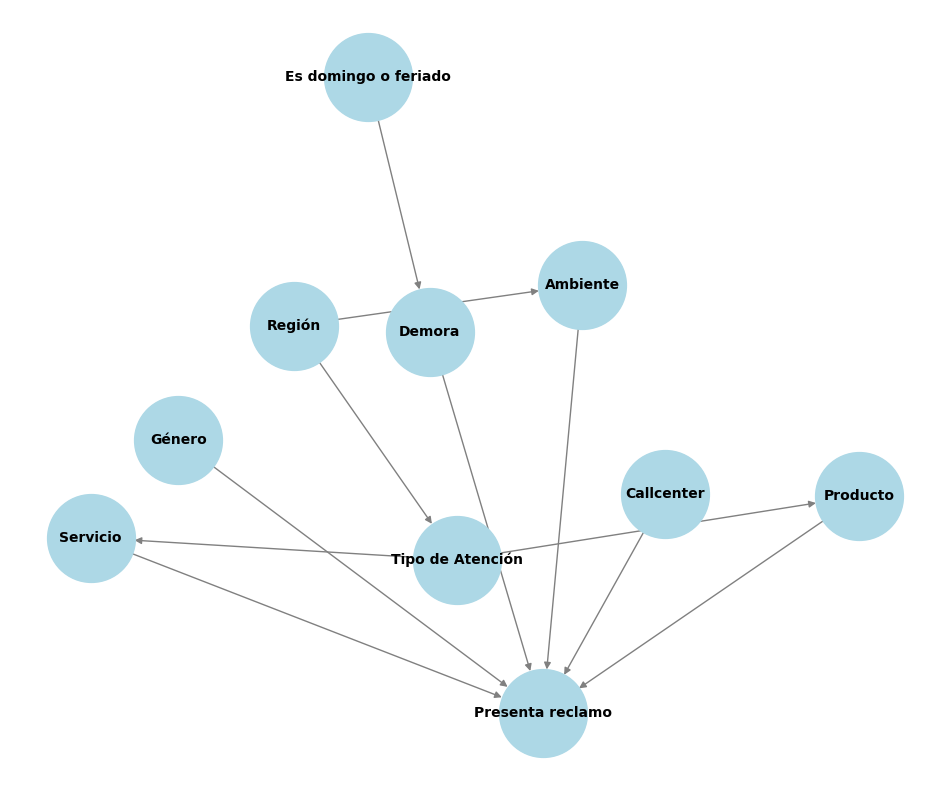

In [11]:
import networkx as nx
import matplotlib.pyplot as plt

nodos = model.nodes()
aristas = model.edges()



red_networkx = nx.DiGraph()
red_networkx.add_nodes_from(nodos)
red_networkx.add_edges_from(aristas)

plt.figure(figsize=(12, 10))
pos = nx.circular_layout(red_networkx)  # Posición de los nodos
nx.draw_networkx(red_networkx,  with_labels=True, node_color='lightblue',
                 node_size=4000, font_size=10, font_weight='bold', edge_color='gray')

plt.axis('off')
plt.show()



In [12]:
from pgmpy.inference import VariableElimination
from pgmpy.inference import BeliefPropagation

ve_infe = VariableElimination(model)
bp_infe = BeliefPropagation(model)

typeservice = variables_model['TYPESERVICE']['name']
sundholi = variables_model['SUNDHOLI']['name']
service = variables_model['SERVICE']['name']
product = variables_model['PRODUCT']['name']
delay = variables_model['DELAY']['name']
atmosphere = variables_model['ATMOSPHERE']['name']
genre = variables_model['GENRE']['name']
region = variables_model['REGION']['name']
callcenter = variables_model['CALLCENTER']['name']
claim = variables_model['CLAIM']['name']


### 1 ¿Cuál es la probabilidad de que se genere un reclamo de la zona Sur por un mal producto vendido por el canal Delivery?



In [13]:
belief = ve_infe.query(variables=[claim], evidence={typeservice:'Delivery',region:'Sur',service:'Bueno',atmosphere:'Agradable',product:'Malo'})

print(belief)


+----------------------+-------------------------+
| Presenta reclamo     |   phi(Presenta reclamo) |
+======================+=========================+
| Presenta reclamo(Sí) |                  0.9825 |
+----------------------+-------------------------+
| Presenta reclamo(No) |                  0.0175 |
+----------------------+-------------------------+


### 2 ¿Cuál es el género qué es menos paciente con la demora en el servicio?

In [14]:
belief = ve_infe.query(variables=[typeservice,genre],evidence={delay:'Sí',service:'Bueno',atmosphere:'Agradable',product:'Bueno',claim:'Sí'})

print(belief)




+----------------------------+-------------------+--------------------------------+
| Tipo de Atención           | Género            |   phi(Tipo de Atención,Género) |
+============================+===================+================================+
| Tipo de Atención(Local)    | Género(Masculino) |                         0.2420 |
+----------------------------+-------------------+--------------------------------+
| Tipo de Atención(Local)    | Género(Femenino)  |                         0.3426 |
+----------------------------+-------------------+--------------------------------+
| Tipo de Atención(Delivery) | Género(Masculino) |                         0.1720 |
+----------------------------+-------------------+--------------------------------+
| Tipo de Atención(Delivery) | Género(Femenino)  |                         0.2435 |
+----------------------------+-------------------+--------------------------------+


### 3 Si el cliente llama o es llamado por el call canter es posible que no se llegue a registrar un reclamo

In [15]:
belief = ve_infe.query(variables=[claim],evidence={callcenter:'Llamó',service:'Bueno',product:'Bueno',delay:'No'})

print(belief)

+----------------------+-------------------------+
| Presenta reclamo     |   phi(Presenta reclamo) |
+======================+=========================+
| Presenta reclamo(Sí) |                  0.7169 |
+----------------------+-------------------------+
| Presenta reclamo(No) |                  0.2831 |
+----------------------+-------------------------+


### Los domingos y feriados llegan a impactar en la presentación de reclamos

In [16]:
belief = ve_infe.query(variables=[claim],evidence={sundholi:'Sí'})

print(belief)

+----------------------+-------------------------+
| Presenta reclamo     |   phi(Presenta reclamo) |
+======================+=========================+
| Presenta reclamo(Sí) |                  0.9225 |
+----------------------+-------------------------+
| Presenta reclamo(No) |                  0.0775 |
+----------------------+-------------------------+


### Cuanto impacta un ambiente desagradable en los reclamos

In [17]:
belief = ve_infe.query(variables=[claim],evidence={service:'Bueno',product:'Bueno',delay:'No',sundholi:'No',atmosphere:'Desagradable'})

print(belief)

+----------------------+-------------------------+
| Presenta reclamo     |   phi(Presenta reclamo) |
+======================+=========================+
| Presenta reclamo(Sí) |                  0.9733 |
+----------------------+-------------------------+
| Presenta reclamo(No) |                  0.0267 |
+----------------------+-------------------------+


### 3.7.2.	¿Cuál es la probabilidad de que se genere un reclamo por demora en un día festivo cuando el pedido fue consumido en el local?

In [19]:
belief = ve_infe.query(variables=[claim],evidence={typeservice:'Local',delay:'Sí',sundholi:'Sí'})

print(belief)

+----------------------+-------------------------+
| Presenta reclamo     |   phi(Presenta reclamo) |
+======================+=========================+
| Presenta reclamo(Sí) |                  0.9076 |
+----------------------+-------------------------+
| Presenta reclamo(No) |                  0.0924 |
+----------------------+-------------------------+


In [ ]:
import pgmpy.estimators as ests
from pgmpy.estimators import TreeSearch
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
from pgmpy.inference import BeliefPropagation
from pgmpy.metrics import structure_score
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score


Building tree:   0%|          | 0/45.0 [00:00<?, ?it/s]

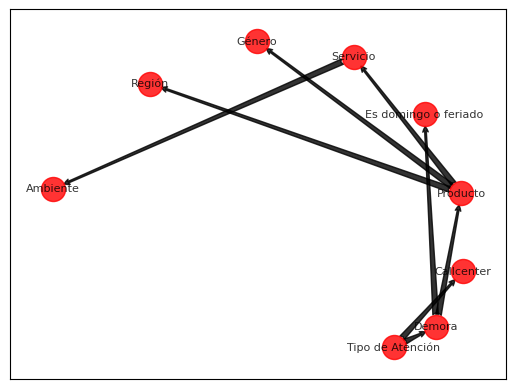

In [106]:

est = TreeSearch(df_select, root_node=variables_model['TYPESERVICE']['name'])

dag = est.estimate(estimator_type='chow-liu')

pos = nx.spiral_layout(dag)
nx.draw_networkx(dag, pos=pos, with_labels=True,node_color='r', font_size=8, arrowstyle='fancy', alpha=0.8)
plt.savefig('plt.png')